# Implementing a denoising autoencoder

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

In this exercise we will develop a denoising autoencoder, and test it out on the MNIST dataset.

In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

We will use the class `DenoisingAutoencoder` in the file `METU/denoising_autoencoder.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
from metu.denoising_autoencoder import DenoisingAutoencoder
from metu.Noise import Noise, GaussianNoise

# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 2
num_inputs = 100
# Outputs are equal to the inputs
network_size = (input_size, hidden_size, input_size)

def init_toy_model(num_inputs, input_size):
  np.random.seed(0)
  net = DenoisingAutoencoder((input_size, hidden_size, input_size))
  net.init_weights()
  return net

def init_toy_data(num_inputs, input_size):
  np.random.seed(1)
  X = np.random.randn(num_inputs, input_size)
  return X

net = init_toy_model(num_inputs, input_size)
X = init_toy_data(num_inputs, input_size)
print "Ok, now we have a toy network"

Ok, now we have a toy network


# Forward pass: compute loss
Open the file `METU/denoising_autoencoder.py` and look at the method `DenoisingAutoencoder.loss`. This function is very similar to the loss functions you have written in the first HWs: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for the corrupted input. In the same function, implement the second part that computes the data and the regularization losses.

In [3]:
loss,_ = net.loss(GaussianNoise(0.5)(X), X, reg=3e-3, activation_function='sigmoid')

correct_loss = 2.42210627243
print 'Your loss value:' + str(loss)

print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Your loss value:2.455512612345061
Difference between your loss and correct loss:
0.03340633991506081


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [4]:
from metu.gradient_check import eval_numerical_gradient

reg = 3e-3

# I think we should use this rel_error but that is not implemented above like previous part of homework
def rel_error(x, y):
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

net.init_weights()
noisy_X = GaussianNoise(0.5)(X)
loss, grads = net.loss(noisy_X, X, reg, activation_function='tanh')

# these should all be less than 1e-5 or so
f = lambda W: net.loss(noisy_X, X, reg, activation_function='tanh')[0]

W1_grad = eval_numerical_gradient(f, net.weights[1]['W'], verbose=False)
print '%s max relative error: %e' % ("W1", rel_error(W1_grad, grads[1]['W']))
W0_grad = eval_numerical_gradient(f, net.weights[0]['W'], verbose=False)
print '%s max relative error: %e' % ("W0", rel_error(W0_grad, grads[0]['W']))

W1 max relative error: 6.383818e-05
W0 max relative error: 1.000000e+00


# Train the network
To train the network we will use stochastic gradient descent (SGD). Look at the function `DenoisingAutoencoder.train_with_SGD` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedures you used in the first HW. 

Once you have implemented the method, run the code below to train the network on toy data. You should achieve a training loss less than 2.0.

Final training loss:  1.3235665362474245


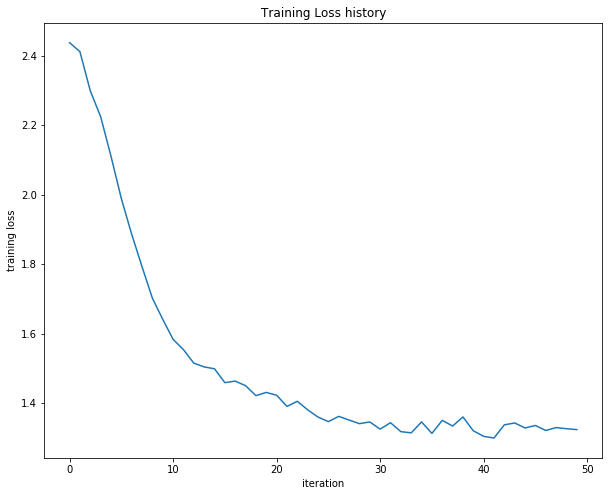

In [5]:
net = init_toy_model(num_inputs, input_size)
reg = 3e-3
stats = net.train_with_SGD(X, noise=GaussianNoise(sd=0.5),
            learning_rate=0.02, learning_rate_decay=0.95, 
            reg=reg, batchsize=100, num_iters=50, verbose=False, activation_function='sigmoid')

print 'Final training loss: ', stats['loss_history'][-1]
# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a DAE network that passes gradient checks and works on toy data, it's time to load up the MNIST dataset so we can use it to train DAE on a real dataset. Make sure that you have run "cs231n/datasets/get_datasets.sh" script before you continue with this step.

In [6]:
from cs231n.data_utils import load_mnist

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
    
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


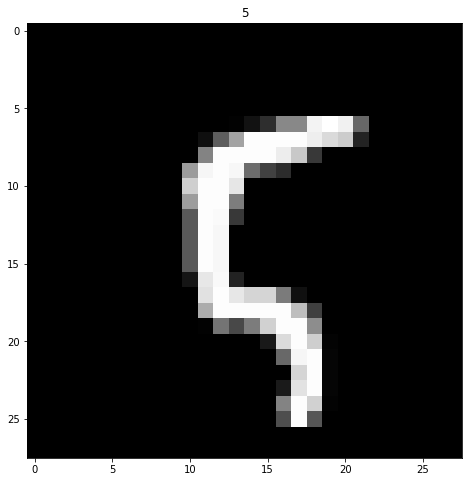

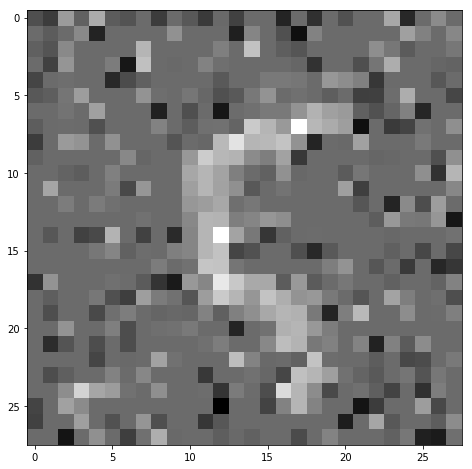

In [7]:
#Visualize some samples

x = np.reshape(X_train[100], (28,28))

plt.imshow(x)
plt.title(y_train[0])
plt.show()

plt.imshow(GaussianNoise(rate=0.5,sd=0.5)(x))
plt.show()
# Yes, DAE will learn to reconstruct from such corrupted data

# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
import time

input_size = 28 * 28
hidden_size = 300 # Try also sizes bigger than 28*28

reg = 0.0001 # 3e-3

net = DenoisingAutoencoder((input_size, hidden_size, input_size))
net.init_weights(13)

# Train with SGD
tic = time.time()
stats = net.train_with_SGD(X_train, noise=GaussianNoise(rate=0.5,sd=0.5),
            learning_rate=0.02, learning_rate_decay=0.95, 
            reg=reg, num_iters=100, batchsize=128, momentum='classic', mu=0.9, verbose=True, 
            activation_function='sigmoid')
toc = time.time()
print toc-tic, 'sec elapsed'

SGD: iteration 0 / 100: loss 106.793278
SGD: iteration 10 / 100: loss 33.615817


SGD: iteration 20 / 100: loss 27.483191
SGD: iteration 30 / 100: loss 19.972333


SGD: iteration 40 / 100: loss 16.458811
SGD: iteration 50 / 100: loss 14.934804


SGD: iteration 60 / 100: loss 13.709550
SGD: iteration 70 / 100: loss 13.572181


SGD: iteration 80 / 100: loss 12.045727
SGD: iteration 90 / 100: loss 12.547057


1.54723405838 sec elapsed


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

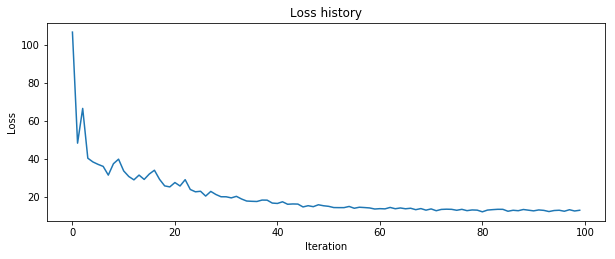

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

/home/ismail/anaconda2/envs/deep/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 299 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


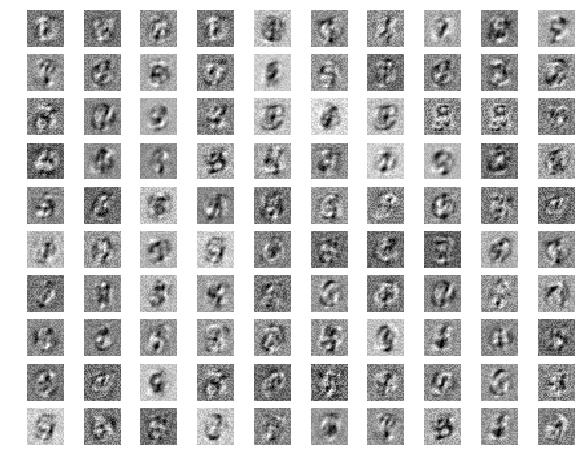

In [10]:
#from cs231n.vis_utils import visualize_grid
#from cs231n.vis_utils import visualize_grid_2D

# SHOW SOME WEIGHTS
W0 = net.weights[0]['W']
W0 = W0.T
num_of_samples=100
for i in range(0,10):
    for j in range(0,10):
        plt.subplot(10, 10, i*10+j+1)
        rand_index = np.random.random_integers(0,W0.shape[0]-1,1)
        plt.imshow(W0[rand_index].reshape(28,28))
        plt.axis('off')
plt.show()

/home/ismail/anaconda2/envs/deep/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 49999 + 1) instead
  after removing the cwd from sys.path.


(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)


(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)


(784, 300) (300, 784) (300,) (784,)


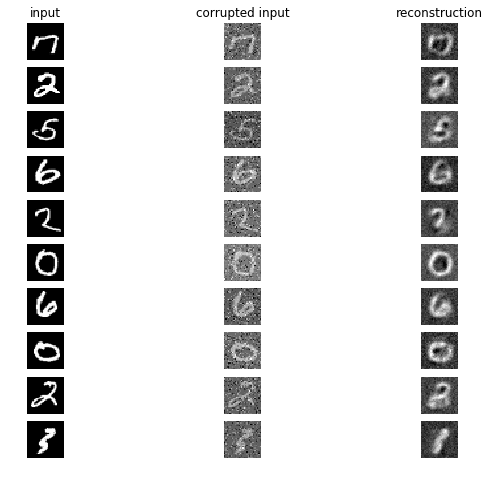

In [11]:
# SHOW SOME RECONSTRUCTIONS
plt_index=1
for i in range(0,10):
    rand_index = np.random.random_integers(0,X_train.shape[0]-1,1)
    x = X_train[rand_index]
    x_noisy = GaussianNoise(rate=0.5,sd=0.5)(x)
    x_recon = net.predict(x_noisy)
    #x_loss,_ = net.loss(x_noisy, x, reg=0.0, activation_function='sigmoid')
    
    plt.subplot(10,3,plt_index)
    plt.imshow(x.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_noisy.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('corrupted input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_recon.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('reconstruction')
    plt_index+=1

# Tune your hyperparameters

**What's wrong?**. Look at the visualizations above and try to come up with strategies for improving your training. With some effort, I came up with the following weights (which are also not perfect) and reconstructions (which are quite good):

<img src="dae_learned_representation.png">

<img src="dae_learned_representation_demo.png">


In [12]:
input_size_ = 28 * 28
hidden_size = 300

reg = 3e-3

net_ = DenoisingAutoencoder((input_size_, hidden_size, input_size_))
net_.init_weights(783)

stats = net_.train_with_SGD(X_train, noise=GaussianNoise(rate=0.5,sd=0.5),
            learning_rate=0.005, learning_rate_decay=0.95, 
            reg=reg, num_iters=1000, batchsize=128, momentum='classic', mu=0.9, verbose=True, 
            activation_function='sigmoid')

SGD: iteration 0 / 1000: loss 101.730597
SGD: iteration 10 / 1000: loss 34.743760


SGD: iteration 20 / 1000: loss 31.636140
SGD: iteration 30 / 1000: loss 27.390926


SGD: iteration 40 / 1000: loss 22.775993
SGD: iteration 50 / 1000: loss 20.620128


SGD: iteration 60 / 1000: loss 19.167159
SGD: iteration 70 / 1000: loss 19.112705


SGD: iteration 80 / 1000: loss 18.012289
SGD: iteration 90 / 1000: loss 17.397743


SGD: iteration 100 / 1000: loss 16.550630
SGD: iteration 110 / 1000: loss 16.964036


SGD: iteration 120 / 1000: loss 16.351183
SGD: iteration 130 / 1000: loss 16.640043


SGD: iteration 140 / 1000: loss 16.801519
SGD: iteration 150 / 1000: loss 15.868090


SGD: iteration 160 / 1000: loss 16.426629


SGD: iteration 170 / 1000: loss 16.522422


SGD: iteration 180 / 1000: loss 16.186132


SGD: iteration 190 / 1000: loss 15.949765
SGD: iteration 200 / 1000: loss 16.576119


SGD: iteration 210 / 1000: loss 15.630991
SGD: iteration 220 / 1000: loss 15.942708


SGD: iteration 230 / 1000: loss 15.846117
SGD: iteration 240 / 1000: loss 15.616063


SGD: iteration 250 / 1000: loss 15.864183
SGD: iteration 260 / 1000: loss 15.992150


SGD: iteration 270 / 1000: loss 15.677913
SGD: iteration 280 / 1000: loss 15.624368


SGD: iteration 290 / 1000: loss 15.512011
SGD: iteration 300 / 1000: loss 16.183825


SGD: iteration 310 / 1000: loss 16.243092


SGD: iteration 320 / 1000: loss 15.512870


SGD: iteration 330 / 1000: loss 14.930876


SGD: iteration 340 / 1000: loss 15.319776


SGD: iteration 350 / 1000: loss 15.498644
SGD: iteration 360 / 1000: loss 15.042433


SGD: iteration 370 / 1000: loss 15.166905
SGD: iteration 380 / 1000: loss 15.729184


SGD: iteration 390 / 1000: loss 15.980111
SGD: iteration 400 / 1000: loss 15.121665


SGD: iteration 410 / 1000: loss 15.363270
SGD: iteration 420 / 1000: loss 15.663026


SGD: iteration 430 / 1000: loss 14.804041
SGD: iteration 440 / 1000: loss 15.450127


SGD: iteration 450 / 1000: loss 15.340297


SGD: iteration 460 / 1000: loss 14.880970


SGD: iteration 470 / 1000: loss 15.826137


SGD: iteration 480 / 1000: loss 15.364089


SGD: iteration 490 / 1000: loss 15.459478
SGD: iteration 500 / 1000: loss 15.145037


SGD: iteration 510 / 1000: loss 15.347785
SGD: iteration 520 / 1000: loss 15.207214


SGD: iteration 530 / 1000: loss 15.275540
SGD: iteration 540 / 1000: loss 14.773389


SGD: iteration 550 / 1000: loss 14.800545
SGD: iteration 560 / 1000: loss 15.689355


SGD: iteration 570 / 1000: loss 16.038900
SGD: iteration 580 / 1000: loss 15.680068


SGD: iteration 590 / 1000: loss 15.302013


SGD: iteration 600 / 1000: loss 15.458614


SGD: iteration 610 / 1000: loss 15.517887


SGD: iteration 620 / 1000: loss 15.400713
SGD: iteration 630 / 1000: loss 15.204370


SGD: iteration 640 / 1000: loss 15.240114
SGD: iteration 650 / 1000: loss 14.737554


SGD: iteration 660 / 1000: loss 15.148196
SGD: iteration 670 / 1000: loss 15.202137


SGD: iteration 680 / 1000: loss 15.441078
SGD: iteration 690 / 1000: loss 15.659490


SGD: iteration 700 / 1000: loss 15.596555
SGD: iteration 710 / 1000: loss 15.680453


SGD: iteration 720 / 1000: loss 15.159393


SGD: iteration 730 / 1000: loss 15.579328


SGD: iteration 740 / 1000: loss 15.681009


SGD: iteration 750 / 1000: loss 15.657255


SGD: iteration 760 / 1000: loss 15.172169
SGD: iteration 770 / 1000: loss 15.956360


SGD: iteration 780 / 1000: loss 15.597655
SGD: iteration 790 / 1000: loss 15.525693


SGD: iteration 800 / 1000: loss 15.234664
SGD: iteration 810 / 1000: loss 15.617344


SGD: iteration 820 / 1000: loss 16.294736
SGD: iteration 830 / 1000: loss 15.506735


SGD: iteration 840 / 1000: loss 14.933057
SGD: iteration 850 / 1000: loss 15.299862


SGD: iteration 860 / 1000: loss 15.409268
SGD: iteration 870 / 1000: loss 15.148525


SGD: iteration 880 / 1000: loss 15.126328
SGD: iteration 890 / 1000: loss 15.228253


SGD: iteration 900 / 1000: loss 15.801695
SGD: iteration 910 / 1000: loss 15.436934


SGD: iteration 920 / 1000: loss 15.059684
SGD: iteration 930 / 1000: loss 15.432346


SGD: iteration 940 / 1000: loss 15.284440
SGD: iteration 950 / 1000: loss 16.209171


SGD: iteration 960 / 1000: loss 15.634620
SGD: iteration 970 / 1000: loss 15.191469


SGD: iteration 980 / 1000: loss 15.556301
SGD: iteration 990 / 1000: loss 15.162510


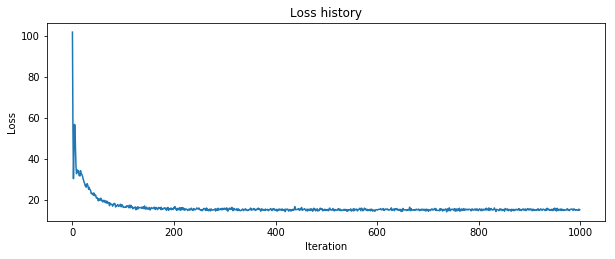

In [13]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()

/home/ismail/anaconda2/envs/deep/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 49999 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)


(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)
(784, 300) (300, 784) (300,) (784,)


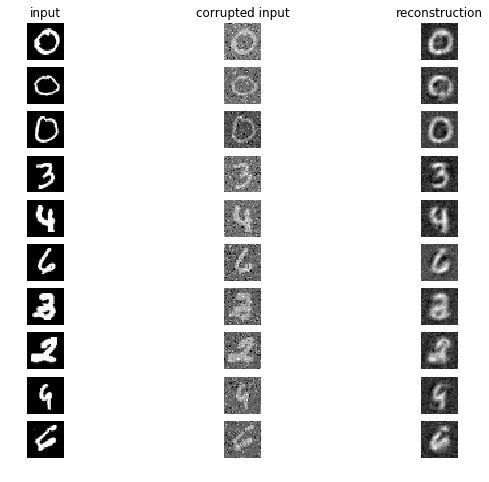

In [14]:
plt_index=1
for i in range(0,10):
    rand_index = np.random.random_integers(0,X_train.shape[0]-1,1)
    x = X_train[rand_index]
    x_noisy = GaussianNoise(rate=0.5,sd=0.5)(x)
    x_recon = net.predict(x_noisy)
    #x_loss,_ = net.loss(x_noisy, x, reg=0.0, activation_function='sigmoid')
    
    plt.subplot(10,3,plt_index)
    plt.imshow(x.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_noisy.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('corrupted input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_recon.reshape(28,28))
    plt.axis('off')
    if i == 0: plt.title('reconstruction')
    plt_index+=1